# Catbooster

## Environment settings

In [1]:
import os
import sys

# Define dataset names.
dataset_name = "hms-harmful-brain-activity-classification"
addition_dataset = "brain-spectrograms"

# Set up for Kaggle.
is_kaggle = "KAGGLE_URL_BASE" in set(os.environ.keys())

# Set-up for Google Colab.
is_colab = True if "google.colab" in sys.modules else False

if is_colab:
    # Mount Google Drive if it is running on Google Colab.
    from google.colab import drive
    drive.mount("/content/drive")

    # Get my kaggle API roken.
    !mkdir -p /root/.kaggle
    !cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    # Prepare for dataset.
    !pip install kaggle
    !apt install unzip
    !mkdir input output
    
    # Get datasets.
    !kaggle competitions download -c {dataset_name}
    !unzip -o {dataset_name}.zip -d input/{dataset_name}
    !rm -r {dataset_name}.zip

    !kaggle datasets download -d cdeotte/{additional_dataset}
    !unzip -o {additional_dataset}.zip -d input/{additional_dataset}
    !rm -r cdeotte/{additional_dataset}
    
    # Install nucessary packages.
    !pip install catboost

print(f"is_kaggle: {is_kaggle}")
print(f"is_colab: {is_colab}")

is_kaggle: True
is_colab: False


In [2]:
# Load libraries.
os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [3]:
model_name = "catboost_1.json"

model_path = f"/kaggle/working/{model_name}"

## Train data preparation

In [4]:
if is_kaggle:
    train_csv_path = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
elif is_colab:
    train_csv_path = f"input/{dataset_name}/train.csv"
else:
    train_csv_path = "./../data/input/train.csv"
    
print(f"Train csv path: {train_csv_path}")

train_df = pd.read_csv(train_csv_path)
targets = train_df.columns[-6:]

print("Train shape: ", train_df.shape)
print("Targets: ", list(targets))

train_df.head()

Train csv path: /kaggle/input/hms-harmful-brain-activity-classification/train.csv
Train shape:  (106800, 15)
Targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### Create Non-Overlapping Eeg Id Train Data

The competition data description says that test data does not have multiple crops from the same eeg_id. Therefore we will train and validate using only 1 crop per eeg_id. There is a discussion about this [discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021).


In [5]:
train_df_grouped_by_eeg_id = train_df.groupby("eeg_id")  # Does not return DataFrame, but for convinience.
train_df_grouped_by_eeg_id

In [6]:
train_df_agg = train_df_grouped_by_eeg_id[["spectrogram_id", "spectrogram_label_offset_seconds"]].agg(
    {"spectrogram_id": "first",
     "spectrogram_label_offset_seconds": "min"}
)
train_df_agg.columns = ["spec_id", "min_offset_secs"]

train_df_agg.head()
# train_df_agg.loc[1628180742]  # See if they are 353733 and 0.

,spec_id,min_offset_secs
eeg_id,,
568657,789577333,0.0
582999,1552638400,0.0
642382,14960202,1008.0
751790,618728447,908.0
778705,52296320,0.0


In [7]:
tmp = train_df_grouped_by_eeg_id[["spectrogram_id", "spectrogram_label_offset_seconds"]].agg(
    {"spectrogram_label_offset_seconds": "max"}
)
train_df_agg['max_offset_secs'] = tmp

train_df_agg.head()

,spec_id,min_offset_secs,max_offset_secs
eeg_id,,,
568657,789577333,0.0,16.0
582999,1552638400,0.0,38.0
642382,14960202,1008.0,1032.0
751790,618728447,908.0,908.0
778705,52296320,0.0,0.0


In [8]:
tmp = train_df_grouped_by_eeg_id[["patient_id"]].agg("first")
train_df_agg['patient_id'] = tmp

train_df_agg.head()

,spec_id,min_offset_secs,max_offset_secs,patient_id
eeg_id,,,,
568657,789577333,0.0,16.0,20654
582999,1552638400,0.0,38.0,20230
642382,14960202,1008.0,1032.0,5955
751790,618728447,908.0,908.0,38549
778705,52296320,0.0,0.0,40955


In [9]:
tmp = train_df_grouped_by_eeg_id[targets].agg("sum")
for target in targets:
    train_df_agg[target] = tmp[target].values

train_df_agg.head()

,spec_id,min_offset_secs,max_offset_secs,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
eeg_id,,,,,,,,,,
568657,789577333,0.0,16.0,20654,0,0,12,0,8,28
582999,1552638400,0.0,38.0,20230,0,132,0,11,0,11
642382,14960202,1008.0,1032.0,5955,0,0,0,0,0,2
751790,618728447,908.0,908.0,38549,0,0,1,0,0,0
778705,52296320,0.0,0.0,40955,0,0,0,0,0,2


In [10]:
tmp = train_df_grouped_by_eeg_id[["expert_consensus"]].agg("first")
train_df_agg["target"] = tmp

train_df_agg.head()

,spec_id,min_offset_secs,max_offset_secs,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
eeg_id,,,,,,,,,,,
568657,789577333,0.0,16.0,20654,0,0,12,0,8,28,Other
582999,1552638400,0.0,38.0,20230,0,132,0,11,0,11,LPD
642382,14960202,1008.0,1032.0,5955,0,0,0,0,0,2,Other
751790,618728447,908.0,908.0,38549,0,0,1,0,0,0,GPD
778705,52296320,0.0,0.0,40955,0,0,0,0,0,2,Other


In [11]:
train_df_agg = train_df_agg.reset_index()
print("Train non-overlapped eeg_id shape: ", train_df_agg.shape)

train_df_agg.head()

Train non-overlapped eeg_id shape:  (17089, 12)


,eeg_id,spec_id,min_offset_secs,max_offset_secs,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0,0,12,0,8,28,Other
1,582999,1552638400,0.0,38.0,20230,0,132,0,11,0,11,LPD
2,642382,14960202,1008.0,1032.0,5955,0,0,0,0,0,2,Other
3,751790,618728447,908.0,908.0,38549,0,0,1,0,0,0,GPD
4,778705,52296320,0.0,0.0,40955,0,0,0,0,0,2,Other


### Feature Engineer
First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from [Brain-Spectrograms dataset](https://www.kaggle.com/datasets/cdeotte/brain-spectrograms), which contains all the 11k spectrograms in less than 1 minute! To use this dataset, set variable READ_SPEC_FILES = False.

Next we need to engineer features for our CatBoost model. In this notebook, we just take the mean (over time) of each of the 400 spectrogram frequencies (using middle 10 minutes). This produces 400 features (per each unique eeg id). We can improve CV and LB score by engineering new features (and/or tuning CatBoost).

Also here we create features from means and mins and use 10 minute windows and 20 second windows.

In [12]:
READ_SPEC_FILES = False
FEATURE_ENGINEER = True

In [13]:
%%time
# Read all spectrograms.
if is_kaggle:
    spectrograms_dir_path = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"
    spectrograms_npy_path = "/kaggle/input/brain-spectrograms/specs.npy"
elif is_colab:
    spectrograms_dir_path = f"input/{dataset_name}/train_spectrograms"
    spectrograms_npy_path = f"input/{addition_dataset}/specs.npy"
else:
    spectrograms_dir_path = "./../data/input/train_spectrograms"
    spectrograms_npy_path = "./../data/input/brain-spectrograms/specs.npy"
    
spectrogram_files = os.listdir(spectrograms_dir_path)

print(f"There are {(len(spectrogram_files))} spectrogram parquets")

if READ_SPEC_FILES:
    spectrograms = {}
    for index, spectrogram_file in enumerate(spectrogram_files):
        if index % 100 == 0:
            print(f"{index}, ", end="")
        tmp = pd.read_parquet(f"{spectrograms_dir_path}{spectrogram_file}")
        name = int(spectrogram_file.split(".")[0])
        spectrograms[name] = tmp.iloc[:, 1:].values
else:
    spectrograms = np.load(spectrograms_npy_path, allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 2.64 s, sys: 6.05 s, total: 8.69 s
Wall time: 56.1 s


In [14]:
%time
# Engineer features.
import warnings
warnings.filterwarnings("ignore")

if is_kaggle:
    train_pqt_path = "kaggle/input/brain-spectrograms/train.pqt"
elif is_colab:
    train_pqt_path = f"input/{addition_dataset}/train.pqt"
else:
    train_pqt_path = "./../data/input/brain-spectrograms/train.pqt"

spec_cols = pd.read_parquet(os.path.join(spectrograms_dir_path, "1000086677.parquet")).columns[1:]
features = [f"{col}_mean_10m" for col in spec_cols]
features += [f"{col}_min_10m" for col in spec_cols]
features += [f"{col}_mean_20m" for col in spec_cols]
features += [f"{col}_min_20m" for col in spec_cols]

print(f"We are creating {len(features)} features for {len(train_df_agg)} rows...", end="")

if FEATURE_ENGINEER:
    data = np.zeros((len(train_df_agg), len(features)))
    for k in range(len(train_df_agg)):
        if k % 100 == 0:
            print(f"{k}, ", end="")
        
        row = train_df_agg.iloc[k]
        r = int((row['min_offset_secs'] + row['max_offset_secs']) // 4)
        
        # 10 minute window features (means and mins)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300, :], axis=0)
        data[k, :400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300, :], axis=0)
        data[k, 400:800] = x
        
        # 20 second window features (means and mins)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155, :], axis=0)
        data[k, 800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155, :], axis=0)
        data[k, 1200:1600] = x
        
    train_df_agg[features] = data
else:
    train_df_agg = pd.read_parquet(train_pqt_path)

print()
print("New train shape: ", train_df_agg.shape)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 7.39 µs
We are creating 1600 features for 17089 rows...0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 

### Train CatBoost
We use the default settings for CatBoost which are pretty good. We can tune CatBoost manually to improve CV and LB score. Note that CatBoost will automatically use both Kaggle T4 GPUs (when we add parameter task_type='GPU') for super fast training!

In [15]:
import catboost as cat, gc
from catboost import CatBoostClassifier, Pool
print("CatBoost version", cat.__version__)

CatBoost version 1.2.2


In [16]:
from sklearn.model_selection import KFold, GroupKFold

all_oof = []
all_true = []

tars = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}

if is_kaggle or is_colab:
    n_splits = 5
else:
    n_splits = 2

group_k_fold = GroupKFold(n_splits=n_splits)

for index, (train_index, valid_index) in enumerate(group_k_fold.split(train_df_agg, train_df_agg.target, train_df_agg.patient_id)):
    print("#" * 25)
    print(f"### Fold {index+1}")
    print(f"### train size {len(train_index)}, valid size {len(valid_index)}")
    print("#" * 25)

    if is_kaggle or is_colab:
        model = CatBoostClassifier(task_type="GPU", loss_function="MultiClass")
    else:
        model = CatBoostClassifier(task_type="CPU", loss_function="MultiClass")

    train_pool = Pool(
        data=train_df_agg.loc[train_index, features],
        label=train_df_agg.loc[train_index, "target"].map(tars),
    )

    valid_pool = Pool(
        data=train_df_agg.loc[valid_index, features],
        label=train_df_agg.loc[valid_index, "target"].map(tars),
    )

    model.fit(train_pool, verbose=100, eval_set=valid_pool)

    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train_df_agg.loc[valid_index, targets].values)

    del train_pool, valid_pool, oof
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

# Save the model.
model.save_model(model_path, format="json")

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.136945
0:	learn: 1.6469715	test: 1.6671148	best: 1.6671148 (0)	total: 270ms	remaining: 4m 29s
100:	learn: 0.7814657	test: 1.1357295	best: 1.1357295 (100)	total: 4.99s	remaining: 44.4s
200:	learn: 0.6224373	test: 1.0949197	best: 1.0949197 (200)	total: 9.16s	remaining: 36.4s
300:	learn: 0.5238836	test: 1.0872521	best: 1.0858146 (275)	total: 13.7s	remaining: 31.7s
400:	learn: 0.4483205	test: 1.0776065	best: 1.0759090 (378)	total: 17.7s	remaining: 26.5s
500:	learn: 0.3912798	test: 1.0805335	best: 1.0759090 (378)	total: 21.8s	remaining: 21.7s
600:	learn: 0.3455538	test: 1.0781553	best: 1.0759090 (378)	total: 26.1s	remaining: 17.4s
700:	learn: 0.3060366	test: 1.0826652	best: 1.0759090 (378)	total: 30.4s	remaining: 13s
800:	learn: 0.2720059	test: 1.0875006	best: 1.0759090 (378)	total: 34.8s	remaining: 8.65s
900:	learn: 0.2430538	test: 1.0864171	best: 1.0759090 (378)	tota

### Feature importance

Below we display the CatBoost top 25 feature importance for the last fold we trained.

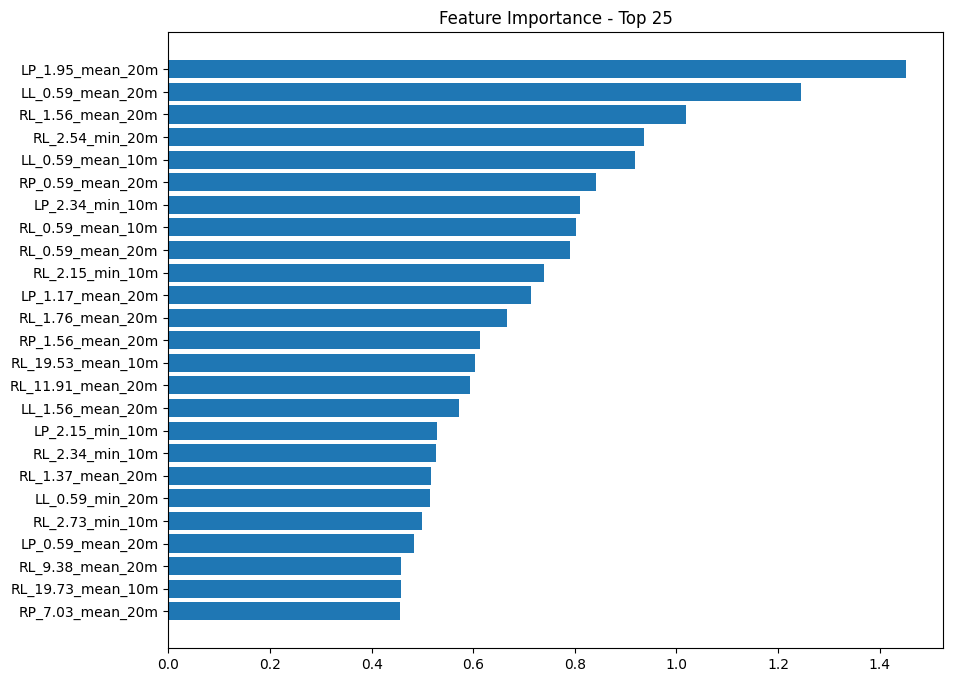

In [17]:
top = 25

feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_indices))[-top:], feature_importance[sorted_indices][-top:], align="center")
plt.yticks(np.arange(len(sorted_indices))[-top:], np.array(features)[sorted_indices][-top:])
plt.title(f"Feature Importance - Top {top}")
plt.show()

### Infer Test and Create Submission CSV
Below we use our 5 CatBoost fold models to infer the test data and create a submission.csv file.

In [18]:
if is_kaggle:
    test_csv_path = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
elif is_colab:
    test_csv_path = f"input/{dataset_name}/test.csv"
else:
    test_csv_path = "./../data/input/test.csv"

test_df = pd.read_csv(test_csv_path)
print("Test shape", test_df.shape)
test_df.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [19]:
# Feature engineer test
if is_kaggle:
    test_spectrograms_dir_path = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
elif is_colab:
    test_spectrograms_dir_path = f"input/{dataset_name}/test_spectrograms"
else:
    test_spectrograms_dir_path = "./../data/input/test_spectrograms"
data = np.zeros((len(test_df),len(features)))
    
for k in range(len(test_df)):
    row = test_df.iloc[k]
    s = int(row.spectrogram_id)
    spec = pd.read_parquet(f'{test_spectrograms_dir_path}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean(spec.iloc[:, 1:].values, axis=0)
    data[k, :400] = x
    x = np.nanmin(spec.iloc[:, 1:].values, axis=0)
    data[k, 400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean(spec.iloc[145:155, 1:].values, axis=0)
    data[k, 800:1200] = x
    x = np.nanmin(spec.iloc[145:155, 1:].values, axis=0)
    data[k, 1200:1600] = x

test_df[features] = data
print("New test shape", test_df.shape)

New test shape (1, 1603)


In [20]:
# Infeer catboost on test
preds = []

for index in range(5):
    print(index, ", ", end="")
    
    if is_kaggle or is_colab:
        model = CatBoostClassifier(task_type="GPU")
    else:
        model = CatBoostClassifier(task_type="CPU")
    
    model.load_model(model_path, format="json")
    
    test_pool = Pool(
        data = test_df[features]
    )
    
    pred = model.predict_proba(test_pool)
    preds.append(pred)

pred = np.mean(preds, axis=0)

print()
print("Test preds shape", pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


In [21]:
submission = pd.DataFrame({
    "eeg_id": test_df.eeg_id.values
})
submission[targets] = pred
submission.to_csv("submission.csv", index=False)

print("Submission shape", submission.shape)
submission.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.392976,0.036163,0.002911,0.145406,0.056144,0.366402


## References
- [CatBoost Starter](https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67)